![](https://ib.bioninja.com.au/_Media/trna-structure_med.jpeg)
In this Notebook I'll try to go through all the data avialable in this competition and give meaning to each aspect, I'll also do some calculations that will shed some light on the nature of this data.

**Side note:** I'm trying to keep this notebook as short as possible wihle highlighiting the most important parts, I'll be updating this notebook regularly to keep up with the  most relevant information related to the problem.

#### Imported packages:
[draw_rna](https://github.com/DasLab/draw_rna)

In [1]:
import sys
sys.path.append('../input/draw-rna')

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from ipynb.draw import draw_struct
import seaborn as sns

plt.style.use('ggplot')

### Loding the json data:

In [3]:
train = pd.read_json('/kaggle/input/stanford-covid-vaccine/train.json', lines=True)
test = pd.read_json('/kaggle/input/stanford-covid-vaccine/test.json', lines=True)

In [4]:
# we define the columns separately (this is gonna be usefull later)
err_cols = ['reactivity_error', 'deg_error_Mg_pH10', 'deg_error_pH10', 'deg_error_Mg_50C', 'deg_error_50C']
mes_cols = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   index                2400 non-null   int64  
 1   id                   2400 non-null   object 
 2   sequence             2400 non-null   object 
 3   structure            2400 non-null   object 
 4   predicted_loop_type  2400 non-null   object 
 5   signal_to_noise      2400 non-null   float64
 6   SN_filter            2400 non-null   int64  
 7   seq_length           2400 non-null   int64  
 8   seq_scored           2400 non-null   int64  
 9   reactivity_error     2400 non-null   object 
 10  deg_error_Mg_pH10    2400 non-null   object 
 11  deg_error_pH10       2400 non-null   object 
 12  deg_error_Mg_50C     2400 non-null   object 
 13  deg_error_50C        2400 non-null   object 
 14  reactivity           2400 non-null   object 
 15  deg_Mg_pH10          2400 non-null   o

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3634 entries, 0 to 3633
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   index                3634 non-null   int64 
 1   id                   3634 non-null   object
 2   sequence             3634 non-null   object
 3   structure            3634 non-null   object
 4   predicted_loop_type  3634 non-null   object
 5   seq_length           3634 non-null   int64 
 6   seq_scored           3634 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 198.9+ KB


As you see the train dataframe has 10 more columns, all these columns are about the measurements and their errors.

#### Our goal is to predict the measurement columns, the errors might be usefull for training the model.

Below we take a look at each column, describe it and try to analyze it.

## Sequence:

(working on it)

## Structure:

The structure column is a string with the same length as the sequence, it indicates if the two bases in the sequence are connected which is noted by parentheses.

We're gonna use the draw_rna tool to plot the structure and also see how the structure impact the measurements.

(0.0, 1.0, 0.0, 1.0)

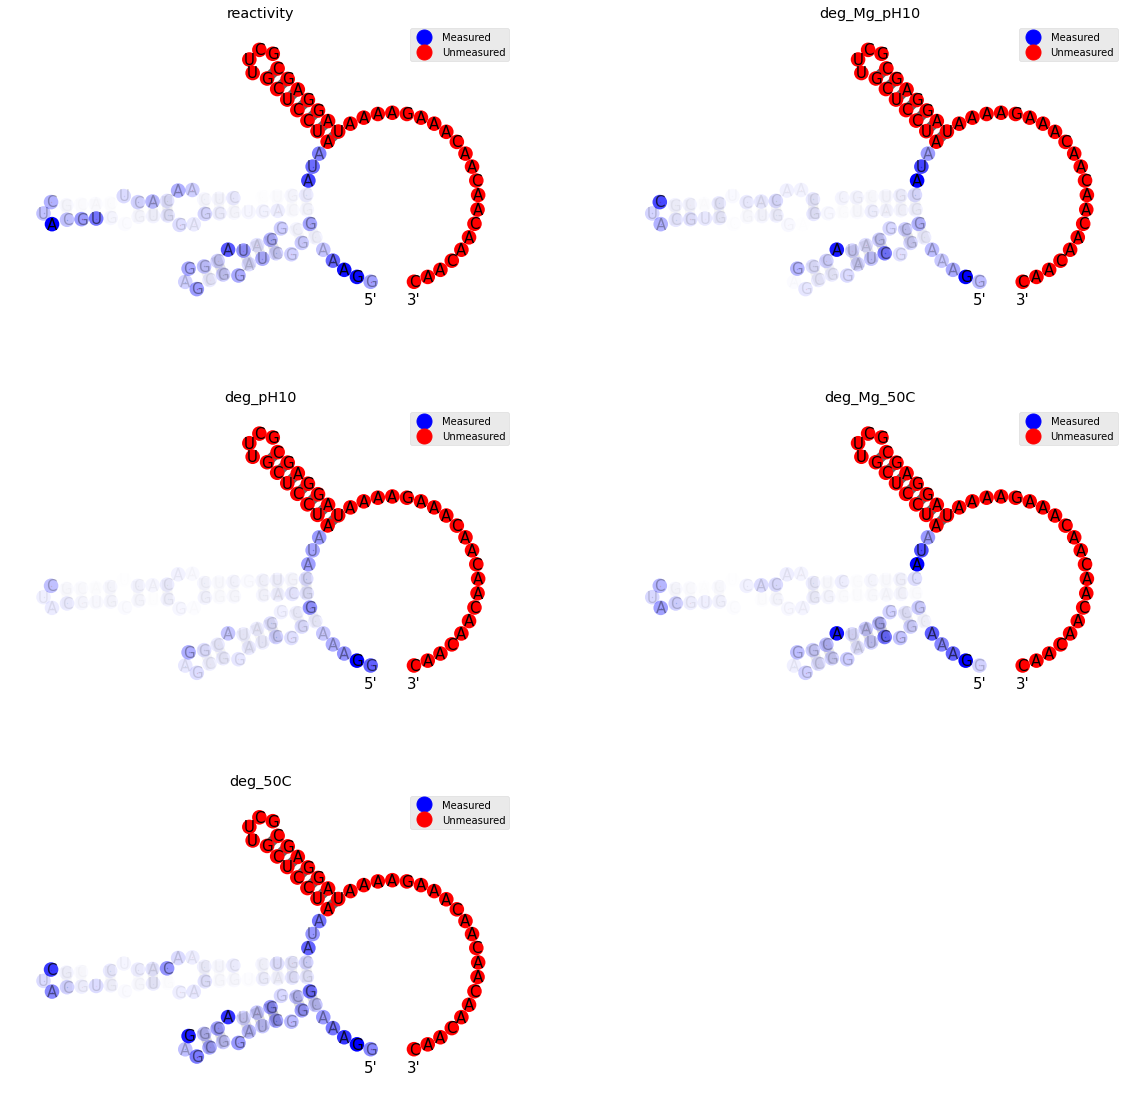

In [7]:
#taking a sample from our training data
    #samples with good confidence 
train_hsnr = train.query('signal_to_noise > 5')
sample = train_hsnr.iloc[49, :]
seq = sample['sequence']
struc = sample['structure']

#ploting the structure with different measurements as alpha

fig, axs = plt.subplots(3, 2, figsize=(20,20))
axs = axs.flatten()
    #for figure Legend
_measured = mlines.Line2D([], [], color='blue', linestyle='None', marker='o', markersize=15, label='Measured')
_unmeasured = mlines.Line2D([], [], color='red', linestyle='None', marker='o', markersize=15, label='Unmeasured')

for i, mes_col in enumerate(mes_cols):
    measure = np.array(sample[mes_col])
    #the last 39 bases aren't measured
    unmeasured = len(seq) - len(measure)
    #normalized the measurement vector (alpha require [0-1] range values)
    norm = (measure - measure.min()) / ( measure.max() - measure.min())
    #padding with ones to have same length
    alpha = np.concatenate((norm, np.ones(unmeasured)))
    #this is to distiguich measured/unmeasured bases
    color = np.concatenate((np.zeros(len(measure)), np.ones(unmeasured)))
    draw_struct(seq, struc, c=color, cmap='bwr', alpha=alpha, ax=axs[i])
    axs[i].set_title(mes_col)
    axs[i].legend(handles=[_measured, _unmeasured])
    
axs[-1].axis('off')

The measured bases seems to have corrolated values (bases on same positions have same opacity for different measurements), we will investigate this further when we analyse these columns.

I have only used a single sample as a visualization, you can be creative try to plot accross different sample taking in regard other parameters.

## Predicted Loop-type:

This feature was creted from the structure, you think of it as an engineered feature (no additional information is added).

## Signal to noise:

Signal to noise is a sort of quality control feature, it's the measurements relative to their errors (we're gonna calculate this column in the next section), this feature can tell us how confident measurements are, the higher value the more confident measurements are.

Let's see how these numbers are distributed:

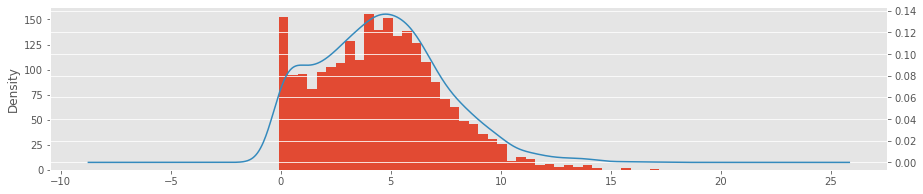

In [8]:
ax = train['signal_to_noise'].plot(kind='hist', bins=40, figsize=(15,3))
train['signal_to_noise'].plot(kind='kde', ax=ax, secondary_y=True)

There seems to be two clusters in this distribution, one in the middle and the other around 0 seems to be some outliers.

In [9]:
#pd.DataFrame(train.query('signal_to_noise == 0').reactivity.values.tolist()).head(2)

In [10]:
#pd.DataFrame(train.query('signal_to_noise == 0').reactivity_error.values.tolist()).head(2)

In [11]:
train['signal_to_noise'].describe()

count    2400.000000
mean        4.530456
std         2.835142
min        -0.103000
25%         2.391000
50%         4.442500
75%         6.294250
max        17.194000
Name: signal_to_noise, dtype: float64

We can see that the values varies significantly from 2 folds relative to the error to 6 folds, I guess a value of 6 is much more confident than 2.
This feature should be taken is consideration when making a model, for example you could use it as training weights.

## How is Signal to noise calculated:

This value is calculated by dividing the each base measurement with it corresponding error value, then averaging all these ratios, as it is shown in the formula below:

$$snr = Avg({\dfrac{measurement_{base}}{error_{base}}})$$

I'm going to use a custom function to caculate the ratio with respect to each row and add it as a new column:

In [12]:
def calc_snr(sample):
    """This function takes a row and return signal to noise
        ratio accross all measurments"""
    ratios = np.zeros(5)
    for i , (deg, err) in enumerate(zip(mes_cols, err_cols)):
        ratio = (np.array(sample[deg]) / np.array(sample[err])).mean()
        ratios[i] = ratio
    return ratios.mean()

In [13]:
train['snr'] = train.apply(calc_snr, axis=1)

In [14]:
train[['signal_to_noise', 'snr']].sample(10)

,signal_to_noise,snr
399,5.351,3.486627
1405,2.464,1.233712
557,4.663,2.956580
351,3.425,2.742465
2161,4.415,2.302827
416,4.759,4.564068
2050,1.838,1.436282
2263,5.602,5.730319
958,3.589,3.125128
584,5.710,3.254540


The numbers are pretty close to what we calculated, let's see how far the calculated numbers are far from the numbers on the dataset:

In [15]:
train.eval('signal_to_noise - snr').mean()

1.1150306133060581

We are off with just a 1, probably this is due to the fact that the numbers where reduced to lower precision floating numbers.

## SN Filter:

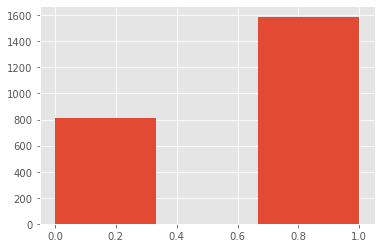

In [16]:
train.SN_filter.hist(bins=3)

## Measurement errors:

I don't know exactly what the statistical significance of these numbers is, one of the Hosts posted a reference about how these columns were obtained: [https://www.kaggle.com/c/stanford-covid-vaccine/discussion/182417](https://www.kaggle.com/c/stanford-covid-vaccine/discussion/182417)

Now we're gonna analyse these errors, let's start by getting the average:

-- we will first avrage with respect to each row then we aggregate:

In [17]:
train['avg_err'] = train[err_cols].applymap(np.mean).mean(axis=1)

Let's take a look at how they are distributed:

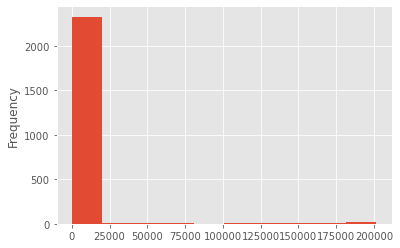

In [18]:
train['avg_err'].plot.hist(bins=10)


the distribution has a long tail, 25000 as an error is probably an outlier, let's look upclose:

In [19]:
train['avg_err'].describe()

count      2400.000000
mean       4204.945952
std       25330.274245
min           0.026284
25%           0.079210
50%           0.109318
75%           0.208025
max      201580.778880
Name: avg_err, dtype: float64

The majority of the values are lower than 1 as we can see from the quantiles.

Let's look why some datapoints have a great error value:

In [20]:
train['avg_err'].quantile(0.94)

1.7996728882352933

In [21]:
#mask = train.query('signal_to_noise > 1')[mes_cols].apply(lambda row: np.any([np.any(np.array(c) == 0) for c in row]), axis=1)
#filtred = train.query('signal_to_noise > 1')[mask]

Plotting errors for one sample. 

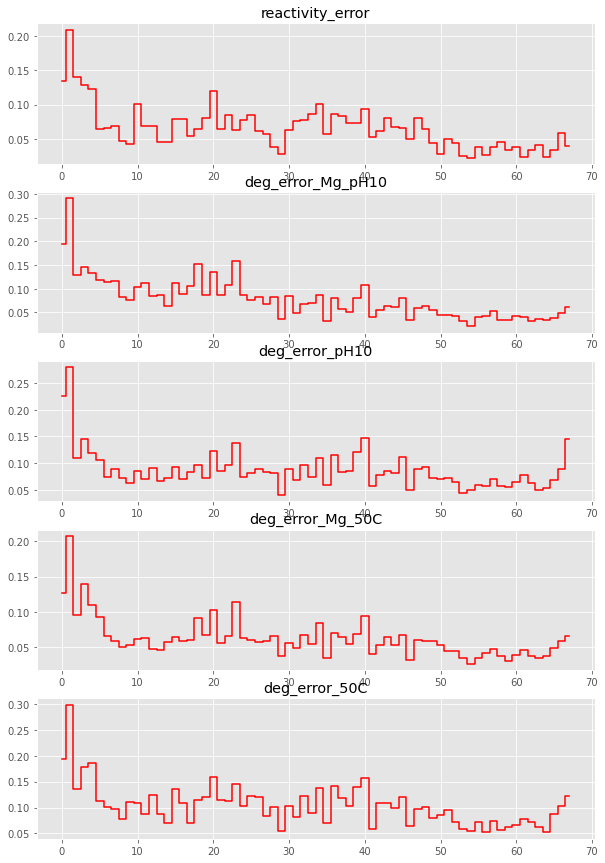

In [22]:
fig, axs = plt.subplots(5,1, figsize=(10, 15))
axs.flatten()
sample = train[train.SN_filter == 1].sample(1).iloc[0]

for i, err_col in enumerate(err_cols):
    axs[i].plot(sample[err_col],color='red', drawstyle='steps-mid')
    axs[i].set_title(err_col)

Some correlation is indeed present. let see the average overage all samples.

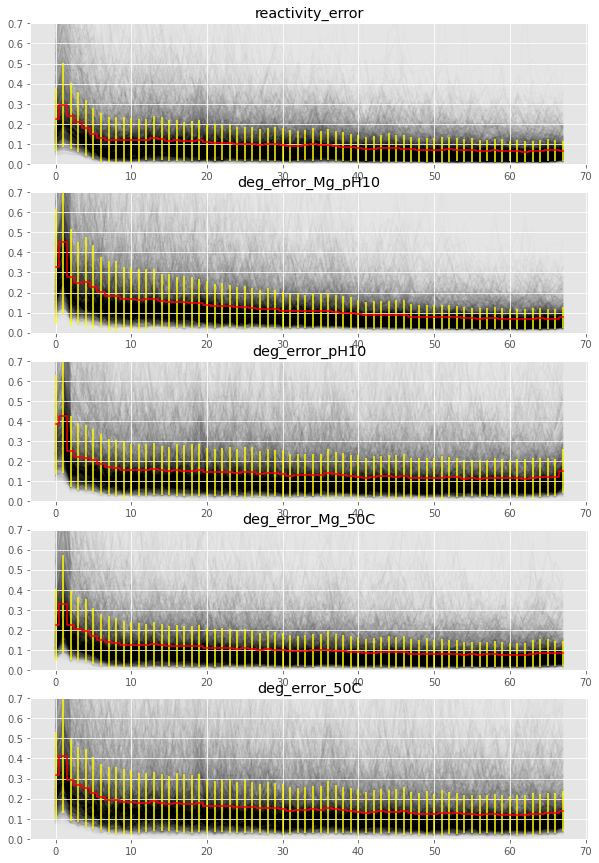

In [23]:
fig, axs = plt.subplots(5,1, figsize=(10, 15))
axs.flatten()

for i, err_col in enumerate(err_cols):
    errs = np.array(train[train.signal_to_noise > 1][err_col].values.tolist())
    for err in errs:
        axs[i].plot(err,color='black', alpha=0.01, zorder=-32)
    errs_avg = errs.mean(axis=0)
    errs_std = errs.std(axis=0)
    axs[i].errorbar(np.arange(68), errs_avg, yerr=errs_std, color='red', ecolor='yellow',  drawstyle='steps-mid')
    axs[i].set_ylim(0, 0.7)
    axs[i].set_title(err_col)

The errors tend to decrease and rise slightly by the end of the sequence.

## Estimating the irreducible error:

I'm assuming the errors are one standard deviation of the mean value accross multiple measurements. We're gonna use only the filtered instances since the private data will be filtered too and also they don't have outliers with huge error values.

$$\text{MSE} = E\big[(y - \hat{f}(x))^2\big]$$
$$= \text{Var}(y) + \text{Var}(\hat{f}(x)) + (y - E[\hat{f}(x)])^2$$
$$= \varepsilon^2 + \text{Var}[\hat{f}(x)] + \text{Bias}[\hat{f}(x)]^2$$

by putting $$\hat{f}(x) = f(x)$$ the bias and variance terms cancel out and we get: $$\text{MSE} = \varepsilon^2$$

(for more details check this [notebook](https://www.kaggle.com/residentmario/bias-variance-tradeoff)).

In [24]:
#Calculating the variances for each measurements
all_var = np.array(train.query('SN_filter == 1')[err_cols].applymap(lambda c: np.array(c) ** 2).values.tolist()) # shape: (1589, 5, 68)

#averaging along the sequence and samples axis
mse = all_var.mean(2).mean(0)

#square root and column-wise mean
mcrmse = np.sqrt(mse).mean()
mcrmse

0.16129185916228592

Fair enough!

## The measurements:

Averaging over all instances with standard deviation as errorbar.

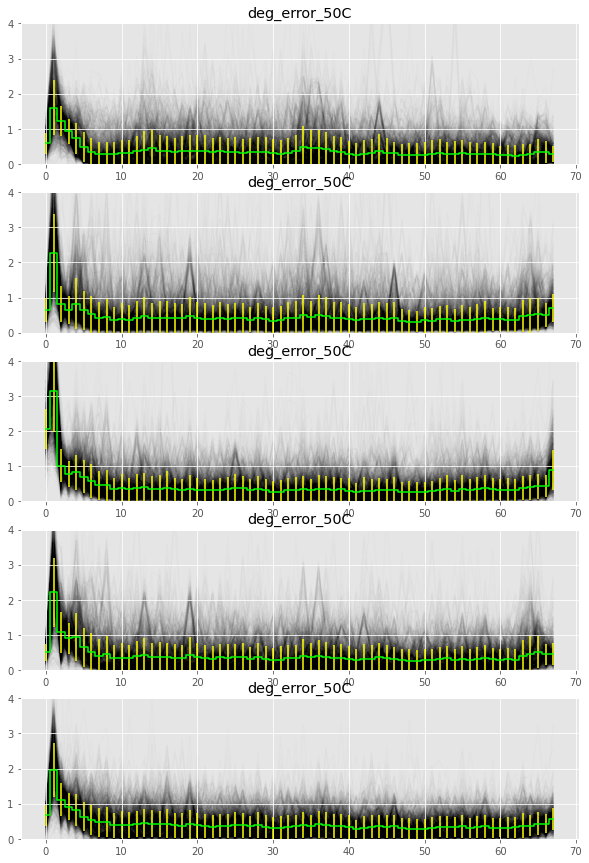

In [25]:
fig, axs = plt.subplots(5,1, figsize=(10, 15))
axs.flatten()

for i, mes_col in enumerate(mes_cols):
    mess = np.array(train[train.SN_filter == 1][mes_col].values.tolist())
    for mes in mess:
        axs[i].plot(mes,color='black', alpha=0.01, zorder=-32)
    mess_avg = mess.mean(axis=0)
    mess_std = mess.std(axis=0)
    axs[i].errorbar(np.arange(68), mess_avg, yerr=mess_std, color='lime', ecolor='yellow', drawstyle='steps-mid')
    axs[i].set_ylim(0, 4)
    axs[i].set_title(err_col)

Ploting one sample with the corresponding error as error bars. (you'll get different sample each time you run the cell bellow ;) ).

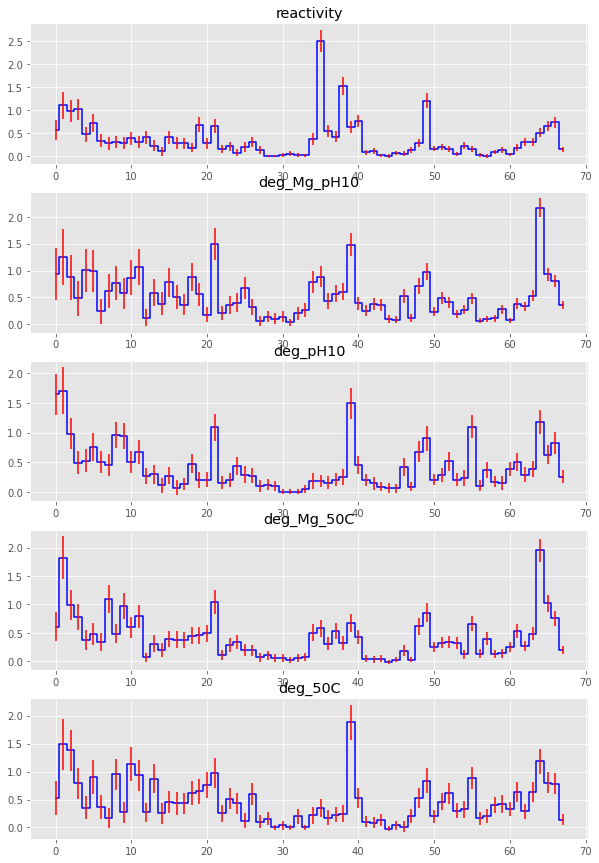

In [26]:
fig, axs = plt.subplots(5,1, figsize=(10, 15))
axs.flatten()
sample = train[train.SN_filter == 1].sample(1).iloc[0]

for i, (mes_col, err_col) in enumerate(zip(mes_cols, err_cols)):
    err = np.array(sample[err_col])
    mes = np.array(sample[mes_col])
    axs[i].errorbar(np.arange(68), mes, yerr=err, color='blue', ecolor='red', drawstyle='steps-mid', barsabove=True)
    axs[i].set_title(mes_col)

There is an obvious correlation between the mesurements.

## bbps files:

The numpy arrays in this folder gives the the probability distribution for each base pair to be connected, the structure feature was basically sampled from these distributions with highest probability. For more details about this refferer to: [What is the bpps folder and the data in each file?](https://www.kaggle.com/c/stanford-covid-vaccine/discussion/182021).

Let's plot the distribution:

In [27]:
sample_id = 'id_20dec87f6'
sample_dist = np.load('../input/stanford-covid-vaccine/bpps/' + sample_id + '.npy')

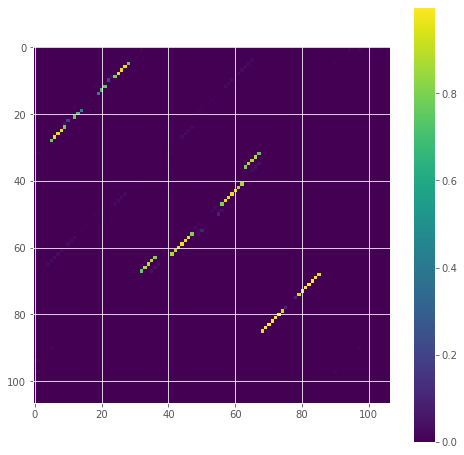

In [28]:
plt.figure(figsize=(8,8))
plt.imshow(sample_dist)
plt.colorbar()

I have made a small algorithm that samples from this distribution, this algorithm gives advantage to pair-base with higher probabilities and has a probability threshold.

In [29]:
def is_loop(sub_struc):
    balance = 0
    for c in sub_struc:
        if balance < 0:
            return True
        if c == b'(':
            balance += 1
        if c == b')':
            balance -= 1
    return balance != 0
    
def sample_struc(_id, min_prob = 0.4):
    dist = np.load('../input/stanford-covid-vaccine/bpps/' + _id + '.npy')
    struc = np.chararray(dist.shape[0])
    struc[:] = '.'
    dist = np.tril(dist)
    while(True):
        if dist.max() < min_prob:
            break
        args = np.argwhere(dist == dist.max())
        for [i, j] in args:
            if not is_loop(struc[j:i]) and struc[i] == b'.':
                #print([j, i, dist.max()])
                struc[i] = ')'
                struc[j] = '('
            dist[i, j] = 0
    return struc.tostring().decode("utf-8") 
        

In [30]:
sample_struct = sample_struc(sample_id)
sample_struct

'.....(((((..(((....)))..)))))...(((((....(((((((........))))))))))))(((((((....))))))).....................'

In [31]:
train.query('id == @sample_id').iloc[0]['structure']

'.....(((((..(((....)))..)))))...(((((....(((((((........))))))))))))(((((((....))))))).....................'

On this sample the algorithm ouputed the same structure from the dataset, let's see how accurate the algorithm is with all the structures in the instances:

In [32]:
ds = pd.concat([train, test])
ds['sample_struc'] = ds['id'].apply(sample_struc)
shape = ds.query('structure == sample_struc').shape

In [33]:
ds.query('structure == sample_struc').shape[0] / ds.shape[0]

0.4221080543586344

About 42% of the instances have the same structure sampled by this simple algorithm, other algorithms probably use other assumptions like give priority to structures with lower energy.

In [34]:
true = list()
for i, c in enumerate(true_struc):
    if c == '(':
        balance = 0
        for j , _c in enumerate(true_struc[i + 1:]):
            if _c == ')' and balance == 0:
                true.append(((i, i + j + 1), sample_dist[i][i + j + 1]))
                break;
            if _c == ')':
                balance -= 1
            if _c == '(':
                balance += 1
true.sort(key=lambda x: x[1], reverse=True)

NameError: name 'true_struc' is not defined

In [35]:
smpld = list()
dist = np.tril(sample_dist)
min_prob = 0.1
while(True):
    if dist.max() < min_prob:
        break
    args = np.argwhere(dist == dist.max())
    for [i, j] in args:
        smpld.append(((j,i), dist.max()))
        dist[i, j] = 0